In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [2]:

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [3]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [4]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(8, 8) (1, 8)
(8, 8) (1, 8)
Alphas for hard margins:  [[9.20094675e-13]
 [3.39925713e+00]
 [7.38679356e-13]
 [1.51331006e-12]
 [2.13379837e-12]
 [1.73701801e-12]
 [1.02773265e-12]
 [9.36199515e-13]
 [6.54542677e-13]
 [1.16762085e-12]
 [8.78151491e-13]
 [1.50395076e-12]
 [1.71057164e-12]
 [1.20875525e-11]
 [2.40314723e-12]
 [1.72206582e-12]
 [2.30705434e-12]
 [1.87262563e-12]
 [8.56836613e-13]
 [1.41980852e-12]
 [1.92485312e-12]
 [2.56992443e-12]
 [1.49710926e-12]
 [2.61895812e-12]
 [2.18760491e+00]
 [8.32973436e-13]
 [1.60512638e-12]
 [1.70050395e-12]
 [2.55783784e-12]
 [1.62923067e-12]
 [3.16987742e-12]
 [1.85109177e-12]
 [3.31039025e-12]
 [1.11954751e-12]
 [7.60232663e-13]
 [1.66417651e-12]
 [3.75392353e-12]
 [5.36911543e-12]
 [1.21655511e-12]
 [8.22506789e-13]
 [8.05634171e+01]
 [1.86812266e-12]
 [1.17243824e-12]
 [1.03660007e-12]
 [1.70157301e-12]
 [7.51099634e-13]
 [5.66562524e+01]
 [1.30678367e-12]
 [1.75962011e-12]
 [1.33464132e-12]
 [1.68060679e-12]
 [1.19435733e-12]
 [8.548794

In [5]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[8.32698135e-13]
 [3.39925713e+00]
 [7.42762381e-13]
 [1.45798034e-12]
 [2.28120023e-12]
 [1.76621333e-12]
 [9.93533704e-13]
 [9.14832110e-13]
 [6.52544540e-13]
 [1.17427192e-12]
 [8.57386725e-13]
 [1.66980840e-12]
 [1.82906324e-12]
 [1.22706950e-11]
 [2.37342034e-12]
 [1.97489514e-12]
 [2.24546082e-12]
 [1.84880960e-12]
 [7.88693134e-13]
 [1.28643940e-12]
 [1.99325536e-12]
 [2.61430250e-12]
 [1.45695962e-12]
 [2.66945690e-12]
 [2.18760491e+00]
 [8.27643376e-13]
 [1.83242325e-12]
 [1.64787767e-12]
 [2.61247063e-12]
 [1.66921210e-12]
 [3.05659222e-12]
 [2.04669163e-12]
 [3.38845401e-12]
 [1.03395036e-12]
 [7.70143311e-13]
 [1.71217188e-12]
 [4.33692619e-12]
 [5.18703853e-12]
 [1.08532193e-12]
 [9.09481679e-13]
 [8.05634171e+01]
 [1.83269470e-12]
 [1.18057258e-12]
 [1.16014044e-12]
 [1.62006811e-12]
 [7.42874522e-13]
 [5.66562524e+01]
 [1.24750361e-12]
 [1.74969553e-12]
 [1.39515689e-12]
 [1.53450594e-12]
 [1.14352319e-12]
 [8.49512645e-13]
 [1.08181697e-12]
 [

<a list of 3 text.Text objects>

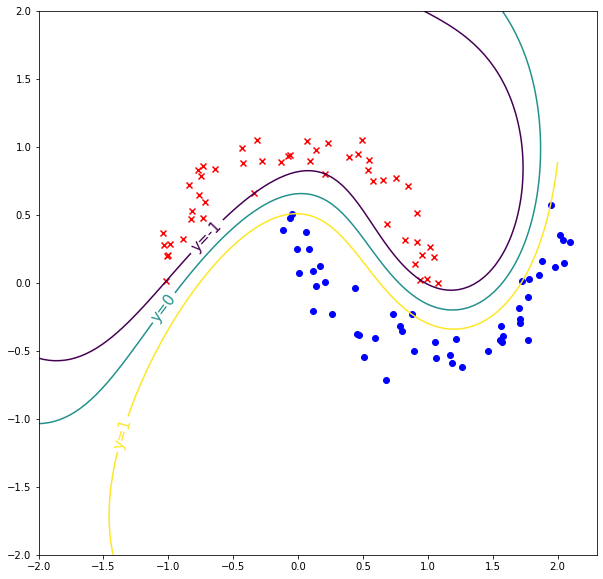

In [6]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)

<a list of 3 text.Text objects>

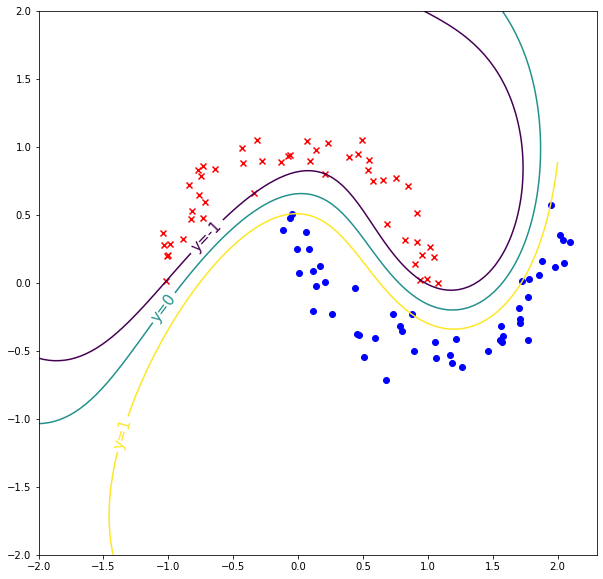

In [7]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)